In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

# display for this notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
os.getcwd()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

'/Users/Bin/repos/competitions/O2O-Coupon-Usage-Forecast'

In [3]:
# import data
dfoff = pd.read_csv('../../ml-datasets/O2O-Coupon-Usage-Forecast/ccf_offline_stage1_train.csv')
dfon = pd.read_csv('../../ml-datasets/O2O-Coupon-Usage-Forecast/ccf_online_stage1_train.csv')
dftest = pd.read_csv('../../ml-datasets/O2O-Coupon-Usage-Forecast/ccf_offline_stage1_test_revised.csv')

## 1. 探索数据
### 1.1 离线数据
#### 1.1.1 离线数据概览

In [21]:
dfoff.info()
# 离线数据一共七列数据，三个 ID 类特征，两个日期类数据，一个字符串，一个连续型数据

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 7 columns):
User_id          int64
Merchant_id      int64
Coupon_id        float64
Discount_rate    object
Distance         float64
Date_received    float64
Date             float64
dtypes: float64(4), int64(2), object(1)
memory usage: 93.7+ MB


Coupon_id（优惠券ID）
* null 表示无优惠券消费，此时Discount_rate和Date_received字段无意义

Discount_rate （优惠率）
* x \in [0,1]代表折扣率；x:y表示满x减y。单位是元

Distance（距离）
* user经常活动的地点离该merchant的最近门店距离是x*500米（如果是连锁店，则取最近的一家门店）
* x\in[0,10]；null表示无此信息，0表示低于500米，10表示大于5公里；

Date_received（领取优惠券日期）

Date（消费日期）
* 如果Date=null & Coupon_id != null，该记录表示领取优惠券但没有使用，即负样本；
* 如果Date!=null & Coupon_id = null，则表示普通消费日期；
* 如果Date!=null & Coupon_id != null，则表示用优惠券消费日期，即正样本；

In [22]:
dfoff.sample(10)
# 优惠券 ID 有不少空的，优惠券领取和消费日期也有不少为空

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
1592552,2976377,760,NaN,NaN,0.0,NaN,20160319.0
21371,1953986,3939,NaN,NaN,7.0,NaN,20160508.0
695752,1608973,7902,3250.0,30:1,NaN,20160514.0,20160515.0
968002,7065586,6597,NaN,NaN,1.0,NaN,20160603.0
711444,4429928,8575,NaN,NaN,1.0,NaN,20160522.0
337996,2510679,5341,NaN,NaN,0.0,NaN,20160304.0
1610742,4571502,6454,14031.0,100:10,NaN,20160202.0,NaN
216402,3112646,4466,NaN,NaN,0.0,NaN,20160502.0
829674,5255660,200,9480.0,20:1,0.0,20160512.0,20160516.0
1022257,2404531,2050,13543.0,200:20,0.0,20160430.0,NaN


In [23]:
dfoff.describe()
# 绝大多数的距离都里商户比较近

,User_id,Merchant_id,Coupon_id,Distance,Date_received,Date
count,1.754884e+06,1.754884e+06,1.053282e+06,1.648881e+06,1.053282e+06,7.769840e+05
mean,3.689255e+06,4.038808e+03,6.815398e+03,2.361636e+00,2.016032e+07,2.016040e+07
std,2.123428e+06,2.435963e+03,4.174276e+03,3.483974e+00,1.771416e+02,1.621500e+02
min,4.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,2.016010e+07,2.016010e+07
25%,1.845052e+06,1.983000e+03,2.840000e+03,0.000000e+00,2.016013e+07,2.016031e+07
50%,3.694446e+06,3.532000e+03,7.430000e+03,0.000000e+00,2.016032e+07,2.016042e+07
75%,5.528759e+06,6.329000e+03,1.032300e+04,3.000000e+00,2.016051e+07,2.016052e+07
max,7.361032e+06,8.856000e+03,1.404500e+04,1.000000e+01,2.016062e+07,2.016063e+07


In [24]:
dfoff.isna().sum()
# 1. 记录中，没有领到优惠券的情况还是比较多
# 2. 领到优惠券没有用的也比较多

User_id               0
Merchant_id           0
Coupon_id        701602
Discount_rate    701602
Distance         106003
Date_received    701602
Date             977900
dtype: int64

In [25]:
dfoff.isna().sum() / (dfoff.count() + dfoff.isna().sum())
# 缺失值比率

User_id          0.000000
Merchant_id      0.000000
Coupon_id        0.399800
Discount_rate    0.399800
Distance         0.060405
Date_received    0.399800
Date             0.557245
dtype: float64

In [26]:
print('有优惠卷，购买商品：%d' % dfoff[(dfoff['Date_received'].notna()) & (dfoff['Date'].notna())].shape[0])
print('有优惠卷，未购商品：%d' % dfoff[(dfoff['Date_received'].notna()) & (dfoff['Date'].isna())].shape[0])
print('无优惠卷，购买商品：%d' % dfoff[(dfoff['Date_received'].isna()) & (dfoff['Date'].notna())].shape[0])
print('无优惠卷，未购商品：%d' % dfoff[(dfoff['Date_received'].isna()) & (dfoff['Date'].isna())].shape[0])
# 有优惠卷，购买商品：75382    ---  正样本
# 有优惠卷，未购商品：977900   ---  大多数还是领了优惠券而不会去用
# 无优惠卷，购买商品：701602   ---  正常买商品，不是因为优惠券的吸引
# 无优惠卷，未购商品：0        ---  说明记录的都是又购买记录
print('正负比例：%f' % (float(dfoff[(dfoff['Date_received'].notna()) & (dfoff['Date'].notna())].shape[0]) / (dfoff.shape[0] - dfoff[(dfoff['Date_received'].notna()) & (dfoff['Date'].notna())].shape[0])))

有优惠卷，购买商品：75382
有优惠卷，未购商品：977900
无优惠卷，购买商品：701602
无优惠卷，未购商品：0
正负比例：0.044884


#### 1.1.2 数据可视化

In [ ]:
from pandas.plotting import scatter_matrix

attrs = ['Discount_rate', 'Distance', 'target']
scatter_matrix(dfoff[attrs], figsize=(12, 8))

In [10]:
# 普通消费
dfoff[dfoff['Date'].notnull() & dfoff['Coupon_id'].isnull()]['Date'].astype(int).value_counts()
# 正样本
dfoff[dfoff['Date'].notnull() & dfoff['Coupon_id'].notnull()]['Date'].astype(int).value_counts()

20160326    9167
20160521    9019
20160327    8907
20160520    8763
20160522    8645
20160325    8441
20160323    7172
20160322    7120
20160321    6980
20160324    6951
20160524    6614
20160523    6571
20160525    6482
20160514    6093
20160513    5684
20160519    5407
20160428    5403
20160516    5264
20160515    5262
20160518    5222
20160512    5105
20160429    5059
20160517    5049
20160605    4963
20160528    4950
20160604    4941
20160529    4919
20160609    4917
20160527    4859
20160601    4821
            ... 
20160203    2670
20160118    2667
20160107    2658
20160121    2638
20160106    2636
20160201    2598
20160223    2559
20160103    2554
20160101    2552
20160111    2493
20160105    2473
20160222    2467
20160220    2457
20160221    2453
20160104    2448
20160219    2434
20160218    2420
20160102    2385
20160217    2371
20160206    2305
20160216    2262
20160214    2199
20160215    2158
20160213    1502
20160212    1304
20160211    1211
20160207    1180
20160210    11

20160330    1421
20160527    1401
20160328    1387
20160329    1362
20160525    1349
20160526    1323
20160327    1318
20160331    1291
20160529    1285
20160528    1253
20160524    1206
20160530    1169
20160325    1164
20160401    1127
20160326    1076
20160522    1068
20160523    1060
20160601    1046
20160531    1028
20160602     963
20160131     881
20160324     874
20160521     864
20160604     826
20160402     825
20160603     796
20160205     775
20160130     754
20160608     727
20160520     709
            ... 
20160320      86
20160304      85
20160109      84
20160312      81
20160319      81
20160305      79
20160112      79
20160106      77
20160313      76
20160110      75
20160311      75
20160307      74
20160318      73
20160107      72
20160316      72
20160301      70
20160310      70
20160314      69
20160315      69
20160308      69
20160309      62
20160302      61
20160303      61
20160317      58
20160321      57
20160103      57
20160105      54
20160104      

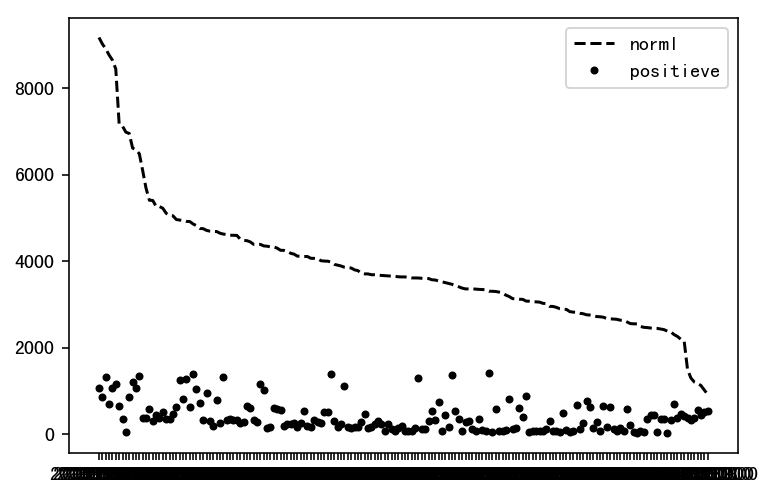

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(dfoff[dfoff['Date'].notnull() & dfoff['Coupon_id'].isnull()]['Date'].astype(str).value_counts(), 'k--', label='norml')
ax.plot(dfoff[dfoff['Date'].notnull() & dfoff['Coupon_id'].notnull()]['Date'].astype(str).value_counts(), 'k.', label='positieve')
ax.legend(loc='best')

## 1.2 线上数据概览

In [43]:
dfon.info()
# 相比线下数据，线上数据没有 distance 特征，多了一个 Action
# Action：0 点击， 1购买，2领取优惠券

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11429826 entries, 0 to 11429825
Data columns (total 7 columns):
User_id          int64
Merchant_id      int64
Action           int64
Coupon_id        object
Discount_rate    object
Date_received    float64
Date             float64
dtypes: float64(2), int64(3), object(2)
memory usage: 610.4+ MB


In [44]:
dfon.sample(10)

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
3265936,13755800,47413,0,NaN,NaN,NaN,20160104.0
8055267,10186566,19401,0,NaN,NaN,NaN,20160521.0
574987,10675199,51810,0,NaN,NaN,NaN,20160504.0
3068998,11935798,56103,0,NaN,NaN,NaN,20160506.0
1643935,13204300,42401,0,NaN,NaN,NaN,20160306.0
8721361,10315931,36701,0,NaN,NaN,NaN,20160614.0
7748845,12378632,15813,0,NaN,NaN,NaN,20160314.0
955234,2845196,36611,1,NaN,NaN,NaN,20160326.0
5575331,14066031,15813,0,NaN,NaN,NaN,20160217.0
6518093,13257364,13200,0,NaN,NaN,NaN,20160220.0


In [12]:
dfon.describe()
# Action 大多数还是只做了点击

,User_id,Merchant_id,Action,Date_received,Date
count,1.142983e+07,1.142983e+07,1.142983e+07,8.723570e+05,1.077393e+07
mean,1.074683e+07,3.436686e+04,2.348193e-01,2.016037e+07,2.016039e+07
std,4.137712e+06,1.441243e+04,5.426314e-01,1.560031e+02,1.732371e+02
min,4.000000e+00,1.000100e+04,0.000000e+00,2.016010e+07,2.016010e+07
25%,1.019827e+07,2.090100e+04,0.000000e+00,2.016023e+07,2.016023e+07
50%,1.196970e+07,3.420000e+04,0.000000e+00,2.016040e+07,2.016041e+07
75%,1.373506e+07,4.741500e+04,0.000000e+00,2.016051e+07,2.016052e+07
max,1.550000e+07,6.000000e+04,2.000000e+00,2.016062e+07,2.016063e+07


In [16]:
dfon.isnull().sum()
# 跟优惠券相关的特征空的比较多

User_id                 0
Merchant_id             0
Action                  0
Coupon_id        10557469
Discount_rate    10557469
Date_received    10557469
Date               655898
dtype: int64

In [20]:
dfoff.sample(10)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,target
661459,2987490,2099,12034.0,0.900000,1,0.227545,0.000000,0
340288,2098527,5479,NaN,0.000000,0,0.000000,0.615385,0
273279,4310885,7555,5582.0,0.833333,0,0.125749,0.000000,0
20119,4142978,5870,NaN,0.000000,6,0.000000,0.280220,0
314230,3346179,5341,NaN,0.000000,1,0.000000,0.142857,0
77093,85695,5341,NaN,0.000000,0,0.000000,0.109890,0
679954,7434,6825,11678.0,0.900000,10,0.682635,0.000000,0
468398,7350919,450,8555.0,0.833333,3,0.173653,0.000000,0
254799,6470213,5341,11539.0,0.833333,0,0.149701,0.230769,1
121011,5267532,8614,332.0,0.833333,3,0.874251,0.000000,0


In [19]:
dfoff['User_id'].nunique()
dfon['User_id'].nunique()
len(list(set(dfoff['User_id']) & set(dfon['User_id'])))
# 可见线上数据和线下数据用户重叠的很少，可以提炼出一些用户的特征

539438

762858

267448

In [23]:
dfoff['Merchant_id'].nunique()
dfon['Merchant_id'].nunique()
len(list(set(dfoff['Merchant_id']) & set(dfon['Merchant_id'])))
# 线上店铺和线下店铺完全没有重叠的部分

8415

7999

0

In [22]:
dftest['User_id'].nunique()
len(list(set(dfoff['User_id']) & set(dftest['User_id'])))
len(np.intersect1d(dfoff['User_id'], dftest['User_id']))
# 测试数据有两个用户不在线下数据内，要特别注意

76309

76307

76307

In [24]:
dftest['Merchant_id'].nunique()
len(list(set(dfoff['Merchant_id']) & set(dftest['Merchant_id'])))
len(np.intersect1d(dfoff['Merchant_id'], dftest['Merchant_id']))
# 测试数据有一个商铺信息不在线下数据内，要注意

1559

1558

1558

## 2. 特征工程
### 2.1 折扣率 Discount_rate
```python
# print(dfoff['Discount_rate'].unique())
[nan '150:20' '20:1' '200:20' '30:5' '50:10' '10:5' '100:10' '200:30'
 '20:5' '30:10' '50:5' '150:10' '100:30' '200:50' '100:50' '300:30'
 '50:20' '0.9' '10:1' '30:1' '0.95' '100:5' '5:1' '100:20' '0.8' '50:1'
 '200:10' '300:20' '100:1' '150:30' '300:50' '20:10' '0.85' '0.6' '150:50'
 '0.75' '0.5' '200:5' '0.7' '30:20' '300:10' '0.2' '50:30' '200:100'
 '150:5']
```

根据打印的结果来看，打折率分为 3 种情况：

* ‘null’ 表示没有打折
* [0,1] 表示折扣率
* x:y 表示满 x 减 y

那我们的处理方式可以构建 4 个函数，分别提取 4 种特征，分别是：

1. 打折类型：Discount_rate_to_type()
2. 折扣率：Discount_rate_zero_to_one()
3. 满多少：getDiscountMan()
4. 减多少：getDiscountJian()

In [ ]:
# 1. 通过不同类型的折扣优惠可以得到类型特征
def Discount_rate_to_type(row):
    if pd.isnull(row):
        return 0
    elif ':' in row:
        return 1
    elif '.' in row:
        return 2

# 2. 将 Discount_rate 字符串转化成 [0, 1]之间小数
def Discount_rate_zero_to_one(row):
    if pd.isnull(row):
        return 0
    if ':' in row:
        sps = row.split(':')
        return (float(sps[0]) - float(sps[1])) / float(sps[0])
    return float(row)

# 3. 统计折扣率满减时需要满多少金额
def Discount_rate_man(row):
    if pd.isnull(row):
        return 0
    if ':' in row:
        rows = row.split(':')
        return int(rows[0])
    else:
        return 0

# 4. 统计折扣率满减时需要满多少金额
def Discount_rate_jian(row):
    if pd.isnull(row):
        return 0
    if ':' in row:
        rows = row.split(':')
        return int(rows[1])
    else:
        return 0
    
# 汇总 Discount_rate 特征提取
def Discount_rate_feat(df):
    df['Discount_rate_type'] = df['Discount_rate'].apply(Discount_rate_to_type)
    df['Discount_rate_ratio'] = df['Discount_rate'].apply(Discount_rate_zero_to_one)
    df['Discount_rate_man'] = df['Discount_rate'].apply(Discount_rate_man)
    df['Discount_rate_jian'] = df['Discount_rate'].apply(Discount_rate_jian)
    # 填充缺失值
    df['Discount_rate'].fillna(0, inplace=True)
    return df

### 2.2 领券时间
还有一点很重要的是领券日期，因为一般而言，周末领取优惠券去消费的可能性更大一些。因此，我们可以构建关于领券日期的一些特征：

* weekday : {null, 1, 2, 3, 4, 5, 6, 7}
* weekday_type : {1, 0}（周六和周日为1，其他为0）
* Weekday_1 : {1, 0, 0, 0, 0, 0, 0}
* Weekday_2 : {0, 1, 0, 0, 0, 0, 0}
* Weekday_3 : {0, 0, 1, 0, 0, 0, 0}
* Weekday_4 : {0, 0, 0, 1, 0, 0, 0}
* Weekday_5 : {0, 0, 0, 0, 1, 0, 0}
* Weekday_6 : {0, 0, 0, 0, 0, 1, 0}
* Weekday_7 : {0, 0, 0, 0, 0, 0, 1}

In [ ]:
# 1. 获取时间是一周的第几天
def get_weekday(row):
    if pd.isnull(row):
        return np.nan
    else:
        return date(int(row[0:4]), int(row(4:6)), int(row[6:8])).weekday() + 1

# 2. 获取是否为周末的特征
def get_weekday_type(row):
    if row in [6, 7]:
        return 1
    else:
        return 0

    
# ## 处理 Date_received，为空的返回为零，其他的按位取
# def Date_received_split_month(row):
#     if pd.isnull(row):
#         return 0
#     row_s = str(int(row))
#     return float(row_s[4:6])

# def Date_received_split_day(row):
#     if pd.isnull(row):
#         return 0
#     row_s = str(int(row))
#     return float(row_s[4:6])

# 汇总 Date_received 特征
def Date_received_feat(df):
#     df['Date_received_month'] = df['Date_received'].apply(Date_received_split_month)
#     df['Date_received_day'] = df['Date_received'].apply(Date_received_split_day)
    
    df['weekday'] = df['Date_received'].astype(str).apply(get_weekday)
    df['weekday_type'] = df['weekday'].apply(get_weekday_type)
    df = pd.concat((df, pd.get_dummies(df['weekday'], prefix='weekday_')), axis=1)
    
    # 处理缺失值
    return df

### 2.3 距离 Distance
距离已经被处理过，那么就主要处理缺失值

In [5]:
# 3. Distance
def Distance_feat(df):
    # 缺失值
    df['Distance'].fillna(df['Distance'].median(), inplace=True)
    
    # 归一化距离
#     df['Distance'] = MinMaxScaler().fit_transform(df['Distance'].values.reshape(-1, 1))
    return df

### 特征工程处理类

In [6]:
# 线下特征处理汇总
def off_feats(df_, no_discount_rate=True):
    # 创建一个拷贝，修改不影响原数据，这样就不用因为原数据被修改从头 run 一遍，节省时间，不要老对内存扣扣搜搜的，硬件问题不会特别大
    df = df_.copy()

    df = Discount_rate_feat(df)
    df = Date_received_feat(df)
    df = Distance_feat(df)
    
    # drop featues
    if no_discount_rate:
        feats = ['Discount_rate', 'Date_received']
        df.drop(feats, axis=1, inplace=True)
    return df

# 待丰富，做特征工程的类
class FeatureConverting(BaseEstimator, TransformerMixin):
    def __init__(self, no_discount_rate=True):
        self.no_discount_rate = no_discount_rate
    def fit(self, X, y=None):
        return self   # Nothing else to do
    def transform(self, X, y=None):
        return off_feats(X, self.no_discount_rate)
#     def fit_transform(self, X, y=None):
#         return off_feats(X)

## 选一个模型

In [82]:
# 单模型测试
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# 管道机制使得参数集在新数据集（比如测试集）上的重复使用，管道机制实现了对全部步骤的流式化封装和管理。
feat_eng = Pipeline([
    ('fc', FeatureConverting()), # transformer
#     ('en', classifier()),  # estimator
])

feats = ['Discount_rate', 'Distance', 'Date_received']
feat_eng_tr = feat_eng.fit_transform(train_off[feats])
feat_eng_ts = feat_eng.transform(test_off[feats])

In [10]:
# 下采样
from imblearn.under_sampling import RandomUnderSampler
cc = RandomUnderSampler(random_state=0)
X_train, y_train = cc.fit_sample(feat_eng_tr, train_off['label'])

clf = RandomForestClassifier().fit(X_train, y_train)
y_pred = clf.predict(feat_eng_ts)

from sklearn.metrics import roc_auc_score
roc_auc_score(test_off['label'], y_pred)

0.8014543094049007

In [15]:
# 对结果预测
submit = dftest[['User_id', 'Coupon_id', 'Date_received']]

feat_dftest = feat_eng.transform(dftest[['Discount_rate', 'Distance', 'Date_received']])

submit['Probability'] = clf.predict_proba(feat_dftest)[:,0]
submit.to_csv('submission.csv', header=None, index=False)

In [9]:
# 多个模型批量跑
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# 管道机制使得参数集在新数据集（比如测试集）上的重复使用，管道机制实现了对全部步骤的流式化封装和管理。
feat_eng = Pipeline([
    ('fc', FeatureConverting()), # transformer
])

feats = ['Discount_rate', 'Distance', 'Date_received']
feat_eng_tr = feat_eng.fit_transform(train_off[feats])
feat_eng_ts = feat_eng.transform(test_off[feats])

# 下采样
from imblearn.under_sampling import RandomUnderSampler
cc = RandomUnderSampler(random_state=0)
X_train, y_train = cc.fit_sample(feat_eng_tr, train_off['label'])

models = tqdm([LogisticRegression(), GaussianNB(), DecisionTreeClassifier(), RandomForestClassifier()])

for model in models:
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(feat_eng_ts)
    print(type(model).__name__, roc_auc_score(test_off['label'], y_pred), accuracy_score(test_off['label'], y_pred))

 50%|█████     | 2/4 [00:00<00:00,  5.19it/s]

('LogisticRegression', 0.7693375293719635, 0.6415463121515085)
('GaussianNB', 0.7250742095294862, 0.5892494379973616)


 75%|███████▌  | 3/4 [00:00<00:00,  5.62it/s]

('DecisionTreeClassifier', 0.8011709837788178, 0.7052598888246239)


100%|██████████| 4/4 [00:01<00:00,  2.99it/s]

('RandomForestClassifier', 0.802024182039111, 0.7051174293472222)


In [ ]:
SVC(gamma='auto'),

In [ ]:
clf = LogisticRegression().fit(feat_eng_tr, feat_eng_tr['label'])
y_pred = clf.predict(feat_eng_ts)

# from sklearn.metrics import accuracy_score
# accuracy_score(test_off['label'], y_pred)
from sklearn.metrics import roc_auc_score
roc_auc_score(test_off['label'], y_pred)

# y_pred = clf.predict(dftest[feats])

# from sklearn.metrics import accuracy_score
# accuracy_score(test_off, y_pred)

In [10]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(FeatureConverting(),
                      LogisticRegression())
model.fit(train_off[['Discount_rate', 'Distance', 'Date_received']], train_off['label'])

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [37]:
# 单模型提交


0    20160712
1    20160706
2    20160727
3    20160727
4    20160708
Name: Date_received, dtype: int64

In [23]:
feats = ['Discount_rate', 'Distance', 'Date_received', 'Date']
y = dfoff['target']
X_train, X_test, y_train, y_test = train_test_split(dfoff[feats], y)

In [24]:
from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression().fit(X_train, y_train)
clf = LogisticRegression()

from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([0.9951602 , 0.99538052, 0.99521335, 0.99548307, 0.99564263])

In [ ]:
clf = LogisticRegression().fit(X_train, y_train)
y_pred = clf.predict(dftest[feats])

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

In [32]:
submit = dftest[['User_id', 'Coupon_id']]
submit['Date_received'] = Date_received
submit['Probability'] = y_pred[:,0]
submit.to_csv('submission.csv', header=None, index=False)

NameError: name 'Date_received' is not defined

## Feature Extract

### 1. 打折率（Discount_rate）

In [127]:
print(dfoff['Discount_rate'].unique())

[nan '150:20' '20:1' '200:20' '30:5' '50:10' '10:5' '100:10' '200:30'
 '20:5' '30:10' '50:5' '150:10' '100:30' '200:50' '100:50' '300:30'
 '50:20' '0.9' '10:1' '30:1' '0.95' '100:5' '5:1' '100:20' '0.8' '50:1'
 '200:10' '300:20' '100:1' '150:30' '300:50' '20:10' '0.85' '0.6' '150:50'
 '0.75' '0.5' '200:5' '0.7' '30:20' '300:10' '0.2' '50:30' '200:100'
 '150:5']


根据打印的结果来看，打折率分为 3 种情况：
* ‘null’ 表示没有打折
* [0,1] 表示折扣率
* x:y 表示满 x 减 y

那我们的处理方式可以构建 4 个函数，分别提取 4 种特征，分别是：

* 打折类型：getDiscountType()
* 折扣率：convertRate()
* 满多少：getDiscountMan()
* 减多少：getDiscountJian()

In [128]:
def getDiscountType(row):
    if row is np.nan:
        return np.nan
    elif ':' in row:
        return 1
    else:
        return 0

def convertRate(row):
    """Convert discount to rate"""
    if row is np.nan:
        return 1.0
    elif ':' in row:
        rows = row.split(':')
        return (float(rows[0])-float(rows[1])) / float(rows[0])
    else:
        return float(row)

def getDiscountMan(row):
    if row is np.nan:
        return 0
    if ':' in row:
        rows = row.split(':')
        return int(rows[0])
    else:
        return 0

def getDiscountJian(row):
    if row is np.nan:
        return 0
    if ':' in row:
        rows = row.split(':')
        return int(rows[1])
    else:
        return 0

def processData(df):
   # convert discount_rate
    df['discount_type'] = df['Discount_rate'].apply(getDiscountType)
    df['discount_rate'] = df['Discount_rate'].apply(convertRate)
    df['discount_man'] = df['Discount_rate'].apply(getDiscountMan)
    df['discount_jian'] = df['Discount_rate'].apply(getDiscountJian)

    print(df['discount_rate'].unique())

    return df

In [129]:
dfoff = processData(dfoff)
dftest = processData(dftest)

[1.         0.86666667 0.95       0.9        0.83333333 0.8
 0.5        0.85       0.75       0.66666667 0.93333333 0.7
 0.6        0.96666667 0.98       0.99       0.975      0.33333333
 0.2        0.4       ]
[0.83333333 0.9        0.96666667 0.8        0.95       0.75
 0.98       0.5        0.86666667 0.6        0.66666667 0.7
 0.85       0.33333333 0.94       0.93333333 0.975      0.99      ]


In [130]:
dfoff.describe()

,User_id,Merchant_id,Coupon_id,Distance,Date_received,Date,discount_type,discount_rate,discount_man,discount_jian
count,1.754884e+06,1.754884e+06,1.053282e+06,1.648881e+06,1.053282e+06,7.769840e+05,1.053282e+06,1.754884e+06,1.754884e+06,1.754884e+06
mean,3.689255e+06,4.038808e+03,6.815398e+03,2.361636e+00,2.016032e+07,2.016040e+07,9.684111e-01,9.065689e-01,4.707850e+01,6.226428e+00
std,2.123428e+06,2.435963e+03,4.174276e+03,3.483974e+00,1.771416e+02,1.621500e+02,1.749030e-01,1.035167e-01,6.801246e+01,8.730104e+00
min,4.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,2.016010e+07,2.016010e+07,0.000000e+00,2.000000e-01,0.000000e+00,0.000000e+00
25%,1.845052e+06,1.983000e+03,2.840000e+03,0.000000e+00,2.016013e+07,2.016031e+07,1.000000e+00,8.333333e-01,0.000000e+00,0.000000e+00
50%,3.694446e+06,3.532000e+03,7.430000e+03,0.000000e+00,2.016032e+07,2.016042e+07,1.000000e+00,9.000000e-01,2.000000e+01,5.000000e+00
75%,5.528759e+06,6.329000e+03,1.032300e+04,3.000000e+00,2.016051e+07,2.016052e+07,1.000000e+00,1.000000e+00,1.000000e+02,1.000000e+01
max,7.361032e+06,8.856000e+03,1.404500e+04,1.000000e+01,2.016062e+07,2.016063e+07,1.000000e+00,1.000000e+00,3.000000e+02,1.000000e+02


### 2. 距离（Distance）
距离字段表示用户与商店的地理距离，显然，距离的远近也会影响到优惠券的使用与否。那么，我们就可以把距离也作为一个特征。首先看一下距离有哪些特征值：

In [131]:
print(dfoff['Distance'].unique())

[ 0.  1. nan  2. 10.  4.  7.  9.  3.  5.  6.  8.]


In [132]:
# convert distance
dfoff['distance'] = dfoff['Distance'].fillna(-1).astype(int)
print(dfoff['distance'].unique())
dftest['distance'] = dftest['Distance'].fillna(-1).astype(int)
print(dftest['distance'].unique())

[ 0  1 -1  2 10  4  7  9  3  5  6  8]
[ 1 -1  5  2  0 10  3  6  7  4  9  8]


In [133]:
dfoff.describe()

,User_id,Merchant_id,Coupon_id,Distance,Date_received,Date,discount_type,discount_rate,discount_man,discount_jian,distance
count,1.754884e+06,1.754884e+06,1.053282e+06,1.648881e+06,1.053282e+06,7.769840e+05,1.053282e+06,1.754884e+06,1.754884e+06,1.754884e+06,1.754884e+06
mean,3.689255e+06,4.038808e+03,6.815398e+03,2.361636e+00,2.016032e+07,2.016040e+07,9.684111e-01,9.065689e-01,4.707850e+01,6.226428e+00,2.158577e+00
std,2.123428e+06,2.435963e+03,4.174276e+03,3.483974e+00,1.771416e+02,1.621500e+02,1.749030e-01,1.035167e-01,6.801246e+01,8.730104e+00,3.470772e+00
min,4.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,2.016010e+07,2.016010e+07,0.000000e+00,2.000000e-01,0.000000e+00,0.000000e+00,-1.000000e+00
25%,1.845052e+06,1.983000e+03,2.840000e+03,0.000000e+00,2.016013e+07,2.016031e+07,1.000000e+00,8.333333e-01,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.694446e+06,3.532000e+03,7.430000e+03,0.000000e+00,2.016032e+07,2.016042e+07,1.000000e+00,9.000000e-01,2.000000e+01,5.000000e+00,0.000000e+00
75%,5.528759e+06,6.329000e+03,1.032300e+04,3.000000e+00,2.016051e+07,2.016052e+07,1.000000e+00,1.000000e+00,1.000000e+02,1.000000e+01,3.000000e+00
max,7.361032e+06,8.856000e+03,1.404500e+04,1.000000e+01,2.016062e+07,2.016063e+07,1.000000e+00,1.000000e+00,3.000000e+02,1.000000e+02,1.000000e+01


In [134]:
dfoff['Date'].isna().sum()

977900

### 3. 领劵日期（Date_received）
是还有一点很重要的是领券日期，因为一般而言，周末领取优惠券去消费的可能性更大一些。因此，我们可以构建关于领券日期的一些特征：

* weekday : {null, 1, 2, 3, 4, 5, 6, 7}
* weekday_type : {1, 0}（周六和周日为1，其他为0）
* Weekday_1 : {1, 0, 0, 0, 0, 0, 0}
* Weekday_2 : {0, 1, 0, 0, 0, 0, 0}
* Weekday_3 : {0, 0, 1, 0, 0, 0, 0}
* Weekday_4 : {0, 0, 0, 1, 0, 0, 0}
* Weekday_5 : {0, 0, 0, 0, 1, 0, 0}
* Weekday_6 : {0, 0, 0, 0, 0, 1, 0}
* Weekday_7 : {0, 0, 0, 0, 0, 0, 1}

In [135]:
def getWeekday(row):
    if row == 'nan':
        return np.nan
    elif row is np.nan:
        return np.nan
    else:
        return date(int(row[0:4]), int(row[4:6]), int(row[6:8])).weekday() + 1

dfoff['weekday'] = dfoff['Date_received'].astype(str).apply(getWeekday)
dftest['weekday'] = dftest['Date_received'].astype(str).apply(getWeekday)

# weekday_type :  周六和周日为1，其他为0
dfoff['weekday_tpye'] = dfoff['weekday'].apply(lambda x: 1 if x in [6, 7] else 0)
dftest['weekday_tpye'] = dftest['weekday'].apply(lambda x: 1 if x in [6, 7] else 0)

# change weekday to one-hot encoding
weekdaycols = ['weekday_' + str(i) for i in range(1,8)]

tmpdf = pd.get_dummies(dfoff['weekday'])
tmpdf.columns = weekdaycols
dfoff[weekdaycols] = tmpdf

tmpdf = pd.get_dummies(dftest['weekday'])
tmpdf.columns = weekdaycols
dftest[weekdaycols] = tmpdf

### 标注标签 Label

有了特征之后，我们还需要对训练样本进行 label 标注，即确定哪些是正样本（y = 1），哪些是负样本（y = 0）。我们要预测的是用户在领取优惠券之后 15 之内的消费情况。所以，总共有三种情况：

1.Date_received == ‘null’：

表示没有领到优惠券，无需考虑，y = -1

2.(Date_received != ‘null’) & (Date != ‘null’) & (Date – Date_received <= 15)：

表示领取优惠券且在15天内使用，即正样本，y = 1

3.(Date_received != ‘null’) & ((Date == ‘null’) | (Date – Date_received > 15))：

表示领取优惠券未在在15天内使用，即负样本，y = 0

好了，知道规则之后，我们就可以定义标签备注函数了。

In [136]:
def label(row):
    if row['Date_received'] == 'nan':
        return -1
    if row['Date'] != 'nan':
        td = pd.to_datetime(row['Date'], format='%Y%m%d') - pd.to_datetime(row['Date_received'], format='%Y%m%d')
        if td <= pd.Timedelta(15, 'D'):
            return 1
    return 0
dfoff['label'] = dfoff.apply(label, axis=1)

KeyboardInterrupt: 

In [ ]:
print(dfoff['label'].value_counts())

很清晰地，正样本共有 64395 例，负样本共有 988887 例。显然，正负样本数量差别很大。这也是为什么会使用 AUC 作为模型性能评估标准的原因。

## 建立模型
接下来就是最主要的建立机器学习模型了。首先确定的是我们选择的特征是上面提取的 14 个特征，为了验证模型的性能，需要划分验证集进行模型验证，划分方式是按照领券日期，即训练集：20160101-20160515，验证集：20160516-20160615。我们采用的模型是简单的 SGDClassifier。

### 1.划分训练集和验证集

In [ ]:
# data split
df = dfoff[dfoff['label'] != -1].copy()
train = df[(df['Date_received'] < '20160516')].copy()
valid = df[(df['Date_received'] >= '20160516') & (df['Date_received'] <= '20160615')].copy()
print('Train Set: \n', train['label'].value_counts())
print('Valid Set: \n', valid['label'].value_counts())

In [ ]:
# feature
original_feature = ['discount_rate','discount_type','discount_man', 'discount_jian','distance', 'weekday', 'weekday_type'] + weekdaycols
print('共有特征：',len(original_feature),'个')
print(original_feature)

### 2. 构建模型

In [ ]:
def check_model(data, predictors):
    classifier = lambda: SGDClassifier(
        loss='log',  # loss function: logistic regression
        penalty='elasticnet', # L1 & L2
        fit_intercept=True,  # 是否存在截距，默认存在
        max_iter=100, 
        shuffle=True,  # Whether or not the training data should be shuffled after each epoch
        n_jobs=1, # The number of processors to use
        class_weight=None) # Weights associated with classes. If not given, all classes are supposed to have weight one.

    # 管道机制使得参数集在新数据集（比如测试集）上的重复使用，管道机制实现了对全部步骤的流式化封装和管理。
    model = Pipeline(steps=[
        ('ss', StandardScaler()), # transformer
        ('en', classifier())  # estimator
    ])

    parameters = {
        'en__alpha': [ 0.001, 0.01, 0.1],
        'en__l1_ratio': [ 0.001, 0.01, 0.1]
    }

    # StratifiedKFold用法类似Kfold，但是他是分层采样，确保训练集，测试集中各类别样本的比例与原始数据集中相同。
    folder = StratifiedKFold(n_splits=3, shuffle=True)

    # Exhaustive search over specified parameter values for an estimator.
    grid_search = GridSearchCV(
        model, 
        parameters, 
        cv=folder, 
        n_jobs=-1,  # -1 means using all processors
        verbose=1)
    grid_search = grid_search.fit(data[predictors], data['label'])

    return grid_search

模型采用的是 SGDClassifier，使用了 Python 中的 Pipeline 管道机制，可以使参数集在新数据集（比如测试集）上的重复使用，管道机制实现了对全部步骤的流式化封装和管理。交叉验证采用 StratifiedKFold，其用法类似 Kfold，但是 StratifiedKFold 是分层采样，确保训练集，测试集中各类别样本的比例与原始数据集中相同。

### 3.训练

接下来就可以使用该模型对训练集进行训练了，整个训练过程大概 1-2 分钟的时间。

In [ ]:
predictors = original_feature
model = check_model(train, predictors)

### 4.验证

然后对验证集中每个优惠券预测的结果计算 AUC，再对所有优惠券的 AUC 求平均。计算 AUC 的时候，如果 label 只有一类，就直接跳过，因为 AUC 无法计算。

In [137]:
# valid predict
y_valid_pred = model.predict_proba(valid[predictors])
valid1 = valid.copy()
valid1['pred_prob'] = y_valid_pred[:, 1]
valid1.head(5)

NameError: name 'model' is not defined

注意这里得到的结果 pred_prob 是概率值（预测样本属于正类的概率）。

最后，就可以对验证集计算 AUC。直接调用 sklearn 库自带的计算 AUC 函数即可。

In [139]:
# avgAUC calculation
vg = valid1.groupby(['Coupon_id'])
aucs = []
for i in vg:
   tmpdf = i[1] 
   if len(tmpdf['label'].unique()) != 2:
       continue
   fpr, tpr, thresholds = roc_curve(tmpdf['label'], tmpdf['pred_prob'], pos_label=1)
   aucs.append(auc(fpr, tpr))
print(np.average(aucs))

NameError: name 'valid1' is not defined

最终得到的 AUC 就等于 0.53。

## 测试
训练完模型之后，就是使用训练好的模型对测试集进行测试了。并且将测试得到的结果（概率值）按照规定的格式保存成一个 .csv 文件。

In [140]:
# test prediction for submission
y_test_pred = model.predict_proba(dftest[predictors])
dftest1 = dftest[['User_id','Coupon_id','Date_received']].copy()
dftest1['Probability'] = y_test_pred[:,1]
dftest1.to_csv('submit.csv', index=False, header=False)
dftest1.head(5)

NameError: name 'model' is not defined

In [ ]:
from IPython.core.display import display, HTML
display(HTML(r"""<style id=hide>div.input{display:none;}</style><button type="button"onclick="var myStyle = document.getElementById('hide').sheet;myStyle.insertRule('div.input{display:inherit !important;}', 0);">Show inputs</button>"""))